# Automatic BSPF Eventplots

Creates automatic event plots based on catalog 

In [1]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from pprint import pprint

from functions.request_data import __request_data
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.compute_adr_pfo import __compute_adr_pfo


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
def __makeplot(config, st):

    
    st_in = st.copy()
    
    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6
    
    for i, tr in enumerate(st_in):
        
        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
            
        ax[i].legend(loc=1)
        
    ax[5].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)
    
    plt.show();
    del st_in
    return fig

In [4]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    st_in = st.copy()
    
    NN = len(st_in)
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
        
    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    font = 14
    
    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st_in):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data*scaling, tr.stats.delta, window=None, normalize=None)
    
    
        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )

        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         
        
        
        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", trans_unit
        else:
            unit = "Amplitude", "a.u."
            
        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)    
        axes[i,1].set_ylabel(f'ASD \n({unit}/Hz)',fontsize=font)        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)",fontsize=font)     

    del st_in
    return fig

In [5]:
def __empty_stream(reference_stream):

    from numpy import ones
    from obspy import Stream, Trace
    
    t_ref = reference_stream[0]
    
    empty = Stream()

    for cha in ["BHZ", "BHN", "BHE"]:
        t = Trace()
        t.data = ones(len(t_ref))
        t.stats.sampling_rate = t_ref.stats.sampling_rate
        t.stats.starttime = t_ref.stats.starttime
        t.stats.network, t.stats.station, t.stats.channel = "PY", "RPFO", cha
        empty += t
        
    return empty

## Configurations

In [6]:
config = {}

## location of BSPF
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## path for figures to store
config['outpath_figs'] = data_path+"BSPF/figures/triggered_all/"

## path for output data
config['outpath_data'] = data_path+"BSPF/data/waveforms/ACC/"

## blueSeis sensor (@200Hz)
config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier (@40Hz)
config['seed_seismometer1'] = "II.PFO.10.BH*"
# config['seed_seismometer1'] = "II.XPFO.30.BH*"

## STS2 next to BlueSeis (@200Hz)
config['seed_seismometer2'] = "PY.PFOIX..HH*"

config['path_to_catalog'] = data_path+"BSPF/data/catalogs/"

config['catalog'] = "BSPF_catalog_20221001_20230930_triggered.pkl"

## Event Info

In [7]:
events = pd.read_pickle(config['path_to_catalog']+config['catalog'])

## RUN LOOP

In [8]:
global errors

errors = []
adr_status = []


for jj, ev in enumerate(tqdm(events.index)):
# for jj, ev in enumerate(events[:10]):

    print(f"\n -> {jj} {events.origin[jj]} ")
    try:
        event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]
    except:
        print(f" -> {jj}: error for event.origin")
        continue

    filename = config['outpath_figs']+"raw/"+f"{event_name}_raw.png"


    ## check if file already exists
    if os.path.isfile(filename):
        print(f" -> file alread exits for {event_name}")
        continue

    ## configuration adjustments
    config['title'] = f"{events.origin[jj]} UTC | M{events.magnitude[jj]}"
    config['tbeg'] = obs.UTCDateTime(str(events.origin[jj]))-15


    ## select appropriate seismometer
    if config['tbeg'].date < obs.UTCDateTime("2023-04-01"):
        config['seed_seismometer'] = config['seed_seismometer1']
        config['fmin'], config['fmax'] = 0.01, 18.0
    else:
        config['seed_seismometer'] = config['seed_seismometer2']
        config['fmin'], config['fmax'] = 0.01, 80.0


    ## same endtime for all
    config['tend'] = obs.UTCDateTime(events.origin[jj])+45


    ## load and process blueSeis data
    try:
        py_bspf0, py_bspf_inv = __request_data(config['seed_blueseis'], config['tbeg'], config['tend'])

    except Exception as e:
        print(e)
        print(f" -> failed to request BSPF for event: {ev}")
        errors.append(f" -> failed to request BSPF for event: {ev}")
        continue

    ## load and process seismometer data
    try:
        ii_pfo0, ii_pfo_inv = __request_data(config['seed_seismometer'], config['tbeg'], config['tend'], translation_type="ACC")

    except Exception as e:
        print(e)
        print(f" -> failed to request BSPF for event: {ev}")
        continue

    if py_bspf0 is None or ii_pfo0 is None:
        continue

    ## processing data
    if ii_pfo0[0].stats.sampling_rate != py_bspf0[0].stats.sampling_rate:
        py_bspf0.resample(ii_pfo0[0].stats.sampling_rate)


    ## joining data
    st0 = py_bspf0
    st0 += ii_pfo0


    ## compute ADR

    ## for complete array
    try:
        pfo_adr, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask="all", status=True)
        for tr in pfo_adr:
            tr.stats.location = "all"
        st0 += pfo_adr
        adr_status.append(status)
    except:
        print(" -> failed to compute ADR all ...")
        pfo_adr = __empty_stream(st0)

    ## for mid array
    try:
        pfo_adr = __compute_adr_pfo(config['tbeg'], config['tend'], submask="mid")
        for tr in pfo_adr:
            tr.stats.location = "mid"
        st0 += pfo_adr
    except:
        print(" -> failed to compute ADR mid ...")
        pfo_adr = __empty_stream(st0)

    ## for inner array
    try:
        pfo_adr = __compute_adr_pfo(config['tbeg'], config['tend'], submask="inner")
        for tr in pfo_adr:
            tr.stats.location = "inn"
        st0 += pfo_adr
    except:
        print(" -> failed to compute ADR inner ...")
        pfo_adr = __empty_stream(st0)

    st0 = st0.sort()

    ## processing data stream
    st = st0.copy();
    st = st.detrend("linear");
    st = st.taper(0.01);
    st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);


    st = st.trim(config['tbeg'], config['tend']);
    st0 = st0.trim(config['tbeg'], config['tend']);

    # print(st0)

    ## store waveform data
    num = str(jj).rjust(3,"0")
    waveform_filename = f"{num}_{str(events.origin[jj]).split('.')[0].replace('-','').replace(':','').replace(' ','_')}.mseed"
    st0.write(config['outpath_data']+waveform_filename, format="MSEED");


    ## create eventname
    # event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]


    ## plotting figures    
    fig1 = st0.plot(equal_scale=False, show=False);

#     fig2 = __makeplot(config, st)

#     fig3 = __makeplotStreamSpectra2(st, config, fscale="linlin");

    ## saving figures
    fig1.savefig(config['outpath_figs']+"raw/"+f"{event_name}_raw.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

#     fig2.savefig(config['outpath_figs']+"filtered/"+f"{event_name}_filtered.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

#     fig3.savefig(config['outpath_figs']+"spectra/"+f"{event_name}_spectra.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


## End of File

  0%|          | 0/228 [00:00<?, ?it/s]


 -> 0 2022-10-01 05:36:11.240000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-01T05:35:01.241400Z - 2022-10-01T05:38:01.216400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-01T05:35:01.241400Z - 2022-10-01T05:38:01.216400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-01T05:35:01.241400Z - 2022-10-01T05:38:01.216400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 1 2022-10-02 03:25:16.440000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-02T03:24:06.441400Z - 2022-10-02T03:27:06.416400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-02T03:24:06.441400Z - 2022-10-02T03:27:06.416400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-02T03:24:06.441400Z - 2022-10-02T03:27:06.416400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 2 2022-10-02 15:51:37.180000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-02T15:50:27.181400Z - 2022-10-02T15:53:27.156400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-02T15:50:27.181400Z - 2022-10-02T15:53:27.156400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-02T15:50:27.181400Z - 2022-10-02T15:53:27.156400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 3 2022-10-02 21:52:54.280000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-02T21:51:44.283900Z - 2022-10-02T21:54:44.258900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-02T21:51:44.283900Z - 2022-10-02T21:54:44.258900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-02T21:51:44.283900Z - 2022-10-02T21:54:44.258900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.38 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes

 -> 4 2022-10-04 22:33:48.370000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-04T22:32:38.372400Z - 2022-10-04T22:35:38.347400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-04T22:32:38.372400Z - 2022-10-04T22:35:38.347400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-04T22:32:38.372400Z - 2022-10-04T22:35:38.347400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 5 2022-10-05 15:39:32.640000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-05T15:38:22.642400Z - 2022-10-05T15:41:22.617400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-05T15:38:22.642400Z - 2022-10-05T15:41:22.617400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-05T15:38:22.642400Z - 2022-10-05T15:41:22.617400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.6 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 6 2022-10-08 02:52:33.350000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-08T02:51:23.352300Z - 2022-10-08T02:54:23.327300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-08T02:51:23.352300Z - 2022-10-08T02:54:23.327300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-08T02:51:23.352300Z - 2022-10-08T02:54:23.327300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 7 2022-10-08 02:59:39.290000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-08T02:58:29.292300Z - 2022-10-08T03:01:29.267300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-08T02:58:29.292300Z - 2022-10-08T03:01:29.267300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-08T02:58:29.292300Z - 2022-10-08T03:01:29.267300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.6 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.35 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes

 -> 8 2022-10-09 08:33:00.550000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-09T08:31:50.554700Z - 2022-10-09T08:34:50.529700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-09T08:31:50.554700Z - 2022-10-09T08:34:50.529700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-09T08:31:50.554700Z - 2022-10-09T08:34:50.529700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes

 -> 9 2022-10-09 11:44:41.790000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-09T11:43:31.790600Z - 2022-10-09T11:46:31.765600Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-09T11:43:31.790500Z - 2022-10-09T11:46:31.765500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-09T11:43:31.790500Z - 2022-10-09T11:46:31.765500Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.35 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 10 2022-10-09 17:51:16.290000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-09T17:50:06.292200Z - 2022-10-09T17:53:06.267200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-09T17:50:06.292200Z - 2022-10-09T17:53:06.267200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-09T17:50:06.292200Z - 2022-10-09T17:53:06.267200Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 11 2022-10-14 03:49:02.940000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-14T03:47:52.944100Z - 2022-10-14T03:50:52.919100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-14T03:47:52.944100Z - 2022-10-14T03:50:52.919100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-14T03:47:52.944100Z - 2022-10-14T03:50:52.919100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.38 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 12 2022-10-15 05:17:34.150000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-15T05:16:24.154100Z - 2022-10-15T05:19:24.129100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-15T05:16:24.154100Z - 2022-10-15T05:19:24.129100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-15T05:16:24.154100Z - 2022-10-15T05:19:24.129100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 13 2022-10-21 08:53:10.210000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-21T08:52:00.213700Z - 2022-10-21T08:55:00.188700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-21T08:52:00.213700Z - 2022-10-21T08:55:00.188700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-21T08:52:00.213700Z - 2022-10-21T08:55:00.188700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 14 2022-10-22 17:23:29.270000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-22T17:22:19.273700Z - 2022-10-22T17:25:19.248700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-22T17:22:19.273700Z - 2022-10-22T17:25:19.248700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-22T17:22:19.273700Z - 2022-10-22T17:25:19.248700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.38 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 15 2022-10-23 09:24:58.150000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-23T09:23:48.153700Z - 2022-10-23T09:26:48.128700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-23T09:23:48.153700Z - 2022-10-23T09:26:48.128700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-23T09:23:48.153700Z - 2022-10-23T09:26:48.128700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.39 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes

 -> 16 2022-10-24 15:39:11.390000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-24T15:38:01.393700Z - 2022-10-24T15:41:01.368700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-24T15:38:01.393700Z - 2022-10-24T15:41:01.368700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-24T15:38:01.393700Z - 2022-10-24T15:41:01.368700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes

 -> 17 2022-10-25 03:55:30.970000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-25T03:54:20.973700Z - 2022-10-25T03:57:20.948700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-25T03:54:20.973700Z - 2022-10-25T03:57:20.948700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-25T03:54:20.973700Z - 2022-10-25T03:57:20.948700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes

 -> 18 2022-10-26 02:14:58.130000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T02:13:48.133700Z - 2022-10-26T02:16:48.108700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-26T02:13:48.133700Z - 2022-10-26T02:16:48.108700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-26T02:13:48.133700Z - 2022-10-26T02:16:48.108700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 19 2022-10-26 08:14:33.950000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T08:13:23.950500Z - 2022-10-26T08:16:23.925500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-26T08:13:23.950500Z - 2022-10-26T08:16:23.925500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-26T08:13:23.950500Z - 2022-10-26T08:16:23.925500Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.38 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 20 2022-10-26 08:26:54.280000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T08:25:44.282900Z - 2022-10-26T08:28:44.257900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-26T08:25:44.282900Z - 2022-10-26T08:28:44.257900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-26T08:25:44.282900Z - 2022-10-26T08:28:44.257900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.59 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes

 -> 21 2022-10-26 10:37:58.930000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T10:36:48.932900Z - 2022-10-26T10:39:48.907900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-26T10:36:48.932900Z - 2022-10-26T10:39:48.907900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-26T10:36:48.932900Z - 2022-10-26T10:39:48.907900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.6 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 22 2022-10-26 10:40:24.830000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T10:39:14.832900Z - 2022-10-26T10:42:14.807900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-26T10:39:14.832900Z - 2022-10-26T10:42:14.807900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-26T10:39:14.832900Z - 2022-10-26T10:42:14.807900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes

 -> 23 2022-10-28 15:14:38.240000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-28T15:13:28.241300Z - 2022-10-28T15:16:28.216300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-10-28T15:13:28.241300Z - 2022-10-28T15:16:28.216300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-10-28T15:13:28.241300Z - 2022-10-28T15:16:28.216300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 24 2022-11-02 09:51:22.090000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-02T09:50:12.091400Z - 2022-11-02T09:53:12.066400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-11-02T09:50:12.091400Z - 2022-11-02T09:53:12.066400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-11-02T09:50:12.091300Z - 2022-11-02T09:53:12.066300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 25 2022-11-09 20:38:02.400000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-09T20:36:52.401300Z - 2022-11-09T20:39:52.376300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-11-09T20:36:52.401300Z - 2022-11-09T20:39:52.376300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-11-09T20:36:52.401300Z - 2022-11-09T20:39:52.376300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes

 -> 26 2022-11-10 07:51:01.120000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-10T07:49:51.121300Z - 2022-11-10T07:52:51.096300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-11-10T07:49:51.121300Z - 2022-11-10T07:52:51.096300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-11-10T07:49:51.121300Z - 2022-11-10T07:52:51.096300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.38 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 27 2022-11-15 16:02:41.970000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-15T16:01:31.971500Z - 2022-11-15T16:04:31.946500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-11-15T16:01:31.971500Z - 2022-11-15T16:04:31.946500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-11-15T16:01:31.971400Z - 2022-11-15T16:04:31.946400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.6 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 28 2022-11-16 01:58:10.850000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-16T01:57:00.851500Z - 2022-11-16T02:00:00.826500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-11-16T01:57:00.851500Z - 2022-11-16T02:00:00.826500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-11-16T01:57:00.851500Z - 2022-11-16T02:00:00.826500Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes

 -> 29 2022-11-19 09:53:11.550000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-19T09:52:01.551000Z - 2022-11-19T09:55:01.526000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-11-19T09:52:01.551000Z - 2022-11-19T09:55:01.526000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-11-19T09:52:01.551000Z - 2022-11-19T09:55:01.526000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.38 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.22 minutes

 -> 30 2022-11-23 15:36:30.450000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-23T15:35:20.451000Z - 2022-11-23T15:38:20.426000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-11-23T15:35:20.451000Z - 2022-11-23T15:38:20.426000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-11-23T15:35:20.451000Z - 2022-11-23T15:38:20.426000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 31 2022-11-25 10:50:33.030000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-25T10:49:23.031100Z - 2022-11-25T10:52:23.006100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-11-25T10:49:23.031100Z - 2022-11-25T10:52:23.006100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-11-25T10:49:23.031100Z - 2022-11-25T10:52:23.006100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.23 minutes

 -> 32 2022-11-27 08:06:51.250000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-27T08:05:41.251100Z - 2022-11-27T08:08:41.226100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-11-27T08:05:41.251100Z - 2022-11-27T08:08:41.226100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-11-27T08:05:41.251100Z - 2022-11-27T08:08:41.226100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes

 -> 33 2022-11-30 14:05:03.530000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-30T14:03:53.532800Z - 2022-11-30T14:06:53.507800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-11-30T14:03:53.532800Z - 2022-11-30T14:06:53.507800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-11-30T14:03:53.532800Z - 2022-11-30T14:06:53.507800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...

 -> Runtime: 0.6 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes

 -> 34 2022-12-01 20:26:07.810000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-01T20:24:57.811200Z - 2022-12-01T20:27:57.786200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-01T20:24:57.811200Z - 2022-12-01T20:27:57.786200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-01T20:24:57.811200Z - 2022-12-01T20:27:57.786200Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 35 2022-12-01 22:23:08.470000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-01T22:21:58.471200Z - 2022-12-01T22:24:58.446200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-01T22:21:58.471200Z - 2022-12-01T22:24:58.446200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-01T22:21:58.471200Z - 2022-12-01T22:24:58.446200Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 36 2022-12-02 03:32:45.040000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-02T03:31:35.041200Z - 2022-12-02T03:34:35.016200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-02T03:31:35.041200Z - 2022-12-02T03:34:35.016200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-02T03:31:35.041200Z - 2022-12-02T03:34:35.016200Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 37 2022-12-02 22:23:52.110000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-02T22:22:42.111200Z - 2022-12-02T22:25:42.086200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-02T22:22:42.111200Z - 2022-12-02T22:25:42.086200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-02T22:22:42.111200Z - 2022-12-02T22:25:42.086200Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.24 minutes

 -> 38 2022-12-05 10:55:32.580000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-05T10:54:22.581200Z - 2022-12-05T10:57:22.556200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-05T10:54:22.581200Z - 2022-12-05T10:57:22.556200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-05T10:54:22.581200Z - 2022-12-05T10:57:22.556200Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 39 2022-12-16 13:51:22.780000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-16T13:50:12.781200Z - 2022-12-16T13:53:12.756200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-16T13:50:12.781200Z - 2022-12-16T13:53:12.756200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-16T13:50:12.781200Z - 2022-12-16T13:53:12.756200Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 40 2022-12-25 08:40:38.690000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-25T08:39:28.693800Z - 2022-12-25T08:42:28.668800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-25T08:39:28.693800Z - 2022-12-25T08:42:28.668800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-25T08:39:28.693800Z - 2022-12-25T08:42:28.668800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 41 2022-12-28 05:50:57.080000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-28T05:49:47.083800Z - 2022-12-28T05:52:47.058800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-28T05:49:47.083800Z - 2022-12-28T05:52:47.058800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-28T05:49:47.083800Z - 2022-12-28T05:52:47.058800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 42 2022-12-31 12:12:26.650000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T12:11:16.653800Z - 2022-12-31T12:14:16.628800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-31T12:11:16.653800Z - 2022-12-31T12:14:16.628800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-31T12:11:16.653700Z - 2022-12-31T12:14:16.628700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.74 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 43 2022-12-31 12:36:38.040000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T12:35:28.040400Z - 2022-12-31T12:38:28.015400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-31T12:35:28.040400Z - 2022-12-31T12:38:28.015400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-31T12:35:28.040400Z - 2022-12-31T12:38:28.015400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 44 2022-12-31 13:15:12.960000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T13:14:02.963700Z - 2022-12-31T13:17:02.938700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-31T13:14:02.963700Z - 2022-12-31T13:17:02.938700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-31T13:14:02.963700Z - 2022-12-31T13:17:02.938700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 45 2022-12-31 14:32:55.050000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T14:31:45.053700Z - 2022-12-31T14:34:45.028700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-31T14:31:45.053700Z - 2022-12-31T14:34:45.028700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-31T14:31:45.053700Z - 2022-12-31T14:34:45.028700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 46 2022-12-31 16:40:07.350000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T16:38:57.353700Z - 2022-12-31T16:41:57.328700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2022-12-31T16:38:57.353700Z - 2022-12-31T16:41:57.328700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2022-12-31T16:38:57.353700Z - 2022-12-31T16:41:57.328700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 47 2023-01-02 03:20:18.170000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-02T03:19:08.174100Z - 2023-01-02T03:22:08.149100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-02T03:19:08.174100Z - 2023-01-02T03:22:08.149100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-02T03:19:08.174100Z - 2023-01-02T03:22:08.149100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 48 2023-01-05 10:00:33.030000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-05T09:59:23.034100Z - 2023-01-05T10:02:23.009100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-05T09:59:23.034100Z - 2023-01-05T10:02:23.009100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-05T09:59:23.034100Z - 2023-01-05T10:02:23.009100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 49 2023-01-05 23:26:23.500000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-05T23:25:13.504100Z - 2023-01-05T23:28:13.479100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-05T23:25:13.504100Z - 2023-01-05T23:28:13.479100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-05T23:25:13.504100Z - 2023-01-05T23:28:13.479100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.48 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 50 2023-01-05 23:44:18.410000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-05T23:43:08.414100Z - 2023-01-05T23:46:08.389100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-05T23:43:08.414100Z - 2023-01-05T23:46:08.389100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-05T23:43:08.414100Z - 2023-01-05T23:46:08.389100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.73 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 51 2023-01-06 13:51:45.470000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-06T13:50:35.474100Z - 2023-01-06T13:53:35.449100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-06T13:50:35.474100Z - 2023-01-06T13:53:35.449100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-06T13:50:35.474100Z - 2023-01-06T13:53:35.449100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 52 2023-01-09 16:59:36.400000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-09T16:58:26.403300Z - 2023-01-09T17:01:26.378300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-09T16:58:26.403300Z - 2023-01-09T17:01:26.378300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-09T16:58:26.403300Z - 2023-01-09T17:01:26.378300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 53 2023-01-09 19:42:56.460000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-09T19:41:46.463300Z - 2023-01-09T19:44:46.438300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-09T19:41:46.463300Z - 2023-01-09T19:44:46.438300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-09T19:41:46.463300Z - 2023-01-09T19:44:46.438300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 54 2023-01-15 09:58:54.070000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-15T09:57:44.073100Z - 2023-01-15T10:00:44.048100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-15T09:57:44.073100Z - 2023-01-15T10:00:44.048100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-15T09:57:44.073100Z - 2023-01-15T10:00:44.048100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 55 2023-01-15 18:03:35.560000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-15T18:02:25.563100Z - 2023-01-15T18:05:25.538100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-15T18:02:25.563100Z - 2023-01-15T18:05:25.538100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-15T18:02:25.563100Z - 2023-01-15T18:05:25.538100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 56 2023-01-15 22:05:20.840000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-15T22:04:10.843100Z - 2023-01-15T22:07:10.818100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-15T22:04:10.843100Z - 2023-01-15T22:07:10.818100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-15T22:04:10.843100Z - 2023-01-15T22:07:10.818100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 57 2023-01-17 11:50:52.860000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-17T11:49:42.863100Z - 2023-01-17T11:52:42.838100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-17T11:49:42.863100Z - 2023-01-17T11:52:42.838100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-17T11:49:42.863100Z - 2023-01-17T11:52:42.838100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 58 2023-01-17 12:16:28.620000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-17T12:15:18.623100Z - 2023-01-17T12:18:18.598100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-17T12:15:18.623100Z - 2023-01-17T12:18:18.598100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-17T12:15:18.623000Z - 2023-01-17T12:18:18.598000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 59 2023-01-18 18:44:40.560000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-18T18:43:30.563100Z - 2023-01-18T18:46:30.538100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-18T18:43:30.563100Z - 2023-01-18T18:46:30.538100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-18T18:43:30.563100Z - 2023-01-18T18:46:30.538100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 60 2023-01-19 01:19:16.080000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-19T01:18:06.083100Z - 2023-01-19T01:21:06.058100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-19T01:18:06.083100Z - 2023-01-19T01:21:06.058100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-19T01:18:06.083100Z - 2023-01-19T01:21:06.058100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 61 2023-01-20 22:36:55.260000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-20T22:35:45.263100Z - 2023-01-20T22:38:45.238100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-20T22:35:45.263100Z - 2023-01-20T22:38:45.238100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-20T22:35:45.263100Z - 2023-01-20T22:38:45.238100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 62 2023-01-21 12:05:52.350000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-21T12:04:42.353000Z - 2023-01-21T12:07:42.328000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-21T12:04:42.353000Z - 2023-01-21T12:07:42.328000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-21T12:04:42.353000Z - 2023-01-21T12:07:42.328000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 63 2023-01-28 05:28:35.930000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-28T05:27:25.933300Z - 2023-01-28T05:30:25.908300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-28T05:27:25.933300Z - 2023-01-28T05:30:25.908300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-28T05:27:25.933300Z - 2023-01-28T05:30:25.908300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 64 2023-01-28 08:37:03.310000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-28T08:35:53.313300Z - 2023-01-28T08:38:53.288300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-28T08:35:53.313300Z - 2023-01-28T08:38:53.288300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-28T08:35:53.313300Z - 2023-01-28T08:38:53.288300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 65 2023-01-29 18:12:03.480000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-29T18:10:53.483300Z - 2023-01-29T18:13:53.458300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-29T18:10:53.483300Z - 2023-01-29T18:13:53.458300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-29T18:10:53.483300Z - 2023-01-29T18:13:53.458300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 66 2023-01-30 20:33:05.830000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-30T20:31:55.832700Z - 2023-01-30T20:34:55.807700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-01-30T20:31:55.832700Z - 2023-01-30T20:34:55.807700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-01-30T20:31:55.832700Z - 2023-01-30T20:34:55.807700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 67 2023-02-02 05:54:33.150000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-02T05:53:23.152800Z - 2023-02-02T05:56:23.127800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-02T05:53:23.152800Z - 2023-02-02T05:56:23.127800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-02T05:53:23.152800Z - 2023-02-02T05:56:23.127800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 68 2023-02-04 19:49:37.680000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-04T19:48:27.683000Z - 2023-02-04T19:51:27.658000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-04T19:48:27.683000Z - 2023-02-04T19:51:27.658000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-04T19:48:27.683000Z - 2023-02-04T19:51:27.658000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 69 2023-02-05 09:25:44.970000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-05T09:24:34.973000Z - 2023-02-05T09:27:34.948000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-05T09:24:34.973000Z - 2023-02-05T09:27:34.948000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-05T09:24:34.973000Z - 2023-02-05T09:27:34.948000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 70 2023-02-06 19:34:45.510000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-06T19:33:35.511700Z - 2023-02-06T19:36:35.486700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-06T19:33:35.511700Z - 2023-02-06T19:36:35.486700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-06T19:33:35.511700Z - 2023-02-06T19:36:35.486700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 71 2023-02-08 17:14:33.500000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-08T17:13:23.502100Z - 2023-02-08T17:16:23.477100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-08T17:13:23.502100Z - 2023-02-08T17:16:23.477100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-08T17:13:23.502100Z - 2023-02-08T17:16:23.477100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 72 2023-02-08 17:58:32.450000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-08T17:57:22.452100Z - 2023-02-08T18:00:22.427100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-08T17:57:22.452100Z - 2023-02-08T18:00:22.427100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-08T17:57:22.452100Z - 2023-02-08T18:00:22.427100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 73 2023-02-08 18:05:42.840000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-08T18:04:32.842100Z - 2023-02-08T18:07:32.817100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-08T18:04:32.842100Z - 2023-02-08T18:07:32.817100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-08T18:04:32.842000Z - 2023-02-08T18:07:32.817000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 74 2023-02-11 15:48:10.640000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-11T15:47:00.641800Z - 2023-02-11T15:50:00.616800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-11T15:47:00.641800Z - 2023-02-11T15:50:00.616800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-11T15:47:00.641800Z - 2023-02-11T15:50:00.616800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 75 2023-02-14 04:32:58.930000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-14T04:31:48.931900Z - 2023-02-14T04:34:48.906900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-14T04:31:48.931900Z - 2023-02-14T04:34:48.906900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-14T04:31:48.931900Z - 2023-02-14T04:34:48.906900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 76 2023-02-17 10:43:21.030000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-17T10:42:11.031900Z - 2023-02-17T10:45:11.006900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-17T10:42:11.031900Z - 2023-02-17T10:45:11.006900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-17T10:42:11.031900Z - 2023-02-17T10:45:11.006900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.4 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 77 2023-02-21 08:25:58.800000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-21T08:24:48.802500Z - 2023-02-21T08:27:48.777500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-21T08:24:48.802500Z - 2023-02-21T08:27:48.777500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-21T08:24:48.802500Z - 2023-02-21T08:27:48.777500Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 78 2023-02-21 19:28:47.220000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-21T19:27:37.222500Z - 2023-02-21T19:30:37.197500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-21T19:27:37.222500Z - 2023-02-21T19:30:37.197500Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-21T19:27:37.222500Z - 2023-02-21T19:30:37.197500Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 79 2023-02-22 00:01:22.710000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-22T00:00:12.712400Z - 2023-02-22T00:03:12.687400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-22T00:00:12.712400Z - 2023-02-22T00:03:12.687400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-22T00:00:12.712400Z - 2023-02-22T00:03:12.687400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 80 2023-02-23 00:04:29.490000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-23T00:03:19.492400Z - 2023-02-23T00:06:19.467400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-23T00:03:19.492400Z - 2023-02-23T00:06:19.467400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-23T00:03:19.492400Z - 2023-02-23T00:06:19.467400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 81 2023-02-24 13:01:57.860000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-24T13:00:47.862300Z - 2023-02-24T13:03:47.837300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-24T13:00:47.862300Z - 2023-02-24T13:03:47.837300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-24T13:00:47.862300Z - 2023-02-24T13:03:47.837300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 82 2023-02-28 05:02:31.330000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-28T05:01:21.332400Z - 2023-02-28T05:04:21.307400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-02-28T05:01:21.332400Z - 2023-02-28T05:04:21.307400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-02-28T05:01:21.332400Z - 2023-02-28T05:04:21.307400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 83 2023-03-01 22:44:47.140000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-01T22:43:37.142400Z - 2023-03-01T22:46:37.117400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-01T22:43:37.142400Z - 2023-03-01T22:46:37.117400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-01T22:43:37.142400Z - 2023-03-01T22:46:37.117400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 84 2023-03-01 22:49:03.580000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-01T22:47:53.582400Z - 2023-03-01T22:50:53.557400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-01T22:47:53.582400Z - 2023-03-01T22:50:53.557400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-01T22:47:53.582400Z - 2023-03-01T22:50:53.557400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes

 -> 85 2023-03-01 23:44:31.150000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-01T23:43:21.152400Z - 2023-03-01T23:46:21.127400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-01T23:43:21.152400Z - 2023-03-01T23:46:21.127400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-01T23:43:21.152400Z - 2023-03-01T23:46:21.127400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 86 2023-03-05 05:10:11.700000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-05T05:09:01.702200Z - 2023-03-05T05:12:01.677200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-05T05:09:01.702200Z - 2023-03-05T05:12:01.677200Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-05T05:09:01.702200Z - 2023-03-05T05:12:01.677200Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 87 2023-03-08 04:07:32.850000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-08T04:06:22.851900Z - 2023-03-08T04:09:22.826900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-08T04:06:22.851900Z - 2023-03-08T04:09:22.826900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-08T04:06:22.851900Z - 2023-03-08T04:09:22.826900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 88 2023-03-08 19:14:49.230000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-08T19:13:39.231900Z - 2023-03-08T19:16:39.206900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-08T19:13:39.231900Z - 2023-03-08T19:16:39.206900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-08T19:13:39.231900Z - 2023-03-08T19:16:39.206900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 89 2023-03-09 10:33:35.540000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-09T10:32:25.541900Z - 2023-03-09T10:35:25.516900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-09T10:32:25.541900Z - 2023-03-09T10:35:25.516900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-09T10:32:25.541900Z - 2023-03-09T10:35:25.516900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 90 2023-03-09 16:15:50.370000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-09T16:14:40.371900Z - 2023-03-09T16:17:40.346900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-09T16:14:40.371900Z - 2023-03-09T16:17:40.346900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-09T16:14:40.371900Z - 2023-03-09T16:17:40.346900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 91 2023-03-09 19:26:19.550000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-09T19:25:09.551900Z - 2023-03-09T19:28:09.526900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-09T19:25:09.551900Z - 2023-03-09T19:28:09.526900Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-09T19:25:09.551900Z - 2023-03-09T19:28:09.526900Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 92 2023-03-10 01:13:29.650000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-10T01:12:19.651800Z - 2023-03-10T01:15:19.626800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-10T01:12:19.651800Z - 2023-03-10T01:15:19.626800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-10T01:12:19.651800Z - 2023-03-10T01:15:19.626800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 93 2023-03-10 06:49:37.800000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-10T06:48:27.801800Z - 2023-03-10T06:51:27.776800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-10T06:48:27.801800Z - 2023-03-10T06:51:27.776800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-10T06:48:27.801800Z - 2023-03-10T06:51:27.776800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 94 2023-03-10 14:32:11.630000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-10T14:31:01.631800Z - 2023-03-10T14:34:01.606800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-10T14:31:01.631800Z - 2023-03-10T14:34:01.606800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-10T14:31:01.631800Z - 2023-03-10T14:34:01.606800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 95 2023-03-10 14:33:14.420000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-10T14:32:04.421800Z - 2023-03-10T14:35:04.396800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-10T14:32:04.421800Z - 2023-03-10T14:35:04.396800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-10T14:32:04.421800Z - 2023-03-10T14:35:04.396800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 96 2023-03-10 15:02:31.670000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-10T15:01:21.671800Z - 2023-03-10T15:04:21.646800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-10T15:01:21.671800Z - 2023-03-10T15:04:21.646800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-10T15:01:21.671800Z - 2023-03-10T15:04:21.646800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 97 2023-03-15 00:03:03.070000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-15T00:01:53.071700Z - 2023-03-15T00:04:53.046700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-15T00:01:53.071700Z - 2023-03-15T00:04:53.046700Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-15T00:01:53.071700Z - 2023-03-15T00:04:53.046700Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 98 2023-03-18 04:52:19.010000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-18T04:51:09.011600Z - 2023-03-18T04:54:08.986600Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-18T04:51:09.011600Z - 2023-03-18T04:54:08.986600Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-18T04:51:09.011600Z - 2023-03-18T04:54:08.986600Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.73 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 99 2023-03-21 04:13:16.460000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-21T04:12:06.462800Z - 2023-03-21T04:15:06.437800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-21T04:12:06.462800Z - 2023-03-21T04:15:06.437800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-21T04:12:06.462800Z - 2023-03-21T04:15:06.437800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 100 2023-03-21 15:34:08.600000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-21T15:32:58.602800Z - 2023-03-21T15:35:58.577800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-21T15:32:58.602800Z - 2023-03-21T15:35:58.577800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-21T15:32:58.602800Z - 2023-03-21T15:35:58.577800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 101 2023-03-21 19:29:23.360000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-21T19:28:13.362800Z - 2023-03-21T19:31:13.337800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-21T19:28:13.362800Z - 2023-03-21T19:31:13.337800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-21T19:28:13.362800Z - 2023-03-21T19:31:13.337800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 102 2023-03-21 20:47:34.330000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-21T20:46:24.332800Z - 2023-03-21T20:49:24.307800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-21T20:46:24.332800Z - 2023-03-21T20:49:24.307800Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-21T20:46:24.332800Z - 2023-03-21T20:49:24.307800Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 103 2023-03-21 23:24:40.990000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-21T23:23:30.992000Z - 2023-03-21T23:26:30.967000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-21T23:23:30.992000Z - 2023-03-21T23:26:30.967000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-21T23:23:30.992000Z - 2023-03-21T23:26:30.967000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 104 2023-03-22 03:21:34.900000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-22T03:20:24.902000Z - 2023-03-22T03:23:24.877000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-22T03:20:24.902000Z - 2023-03-22T03:23:24.877000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-22T03:20:24.902000Z - 2023-03-22T03:23:24.877000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 105 2023-03-22 20:13:47.950000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-22T20:12:37.952000Z - 2023-03-22T20:15:37.927000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-22T20:12:37.952000Z - 2023-03-22T20:15:37.927000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-22T20:12:37.952000Z - 2023-03-22T20:15:37.927000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes

 -> 106 2023-03-26 07:47:55.340000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-26T07:46:45.342000Z - 2023-03-26T07:49:45.317000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-26T07:46:45.342000Z - 2023-03-26T07:49:45.317000Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-26T07:46:45.342000Z - 2023-03-26T07:49:45.317000Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes

 -> 107 2023-03-26 17:50:18.500000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-26T17:49:08.503100Z - 2023-03-26T17:52:08.478100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-26T17:49:08.503100Z - 2023-03-26T17:52:08.478100Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-26T17:49:08.503100Z - 2023-03-26T17:52:08.478100Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 108 2023-03-29 19:40:21.650000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-29T19:39:11.653400Z - 2023-03-29T19:42:11.628400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-29T19:39:11.653400Z - 2023-03-29T19:42:11.628400Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-29T19:39:11.653400Z - 2023-03-29T19:42:11.628400Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes

 -> 109 2023-03-31 12:05:39.920000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-31T12:04:29.923300Z - 2023-03-31T12:07:29.898300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJN | 2023-03-31T12:04:29.923300Z - 2023-03-31T12:07:29.898300Z | 40.0 Hz, 7200 samples
PY.BSPF..HJE | 2023-03-31T12:04:29.923300Z - 2023-03-31T12:07:29.898300Z | 40.0 Hz, 7200 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.74 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes

 -> 110 2023-04-01 01:16:07.810000 
 -> sensitivity removed!
 -> Failed to load inventory!
 -> Failed to load waveforms!
 -> failed to rotate to ZNE

 -> 111 2023-04-01 11:48:24.670000 
 -> sensitivity removed!
 -> Failed to load inventory!
 -> Failed to load waveforms!
 -> failed to rotate to ZNE

 -> 112 2023-04-05 09:09:45.750000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...

 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing

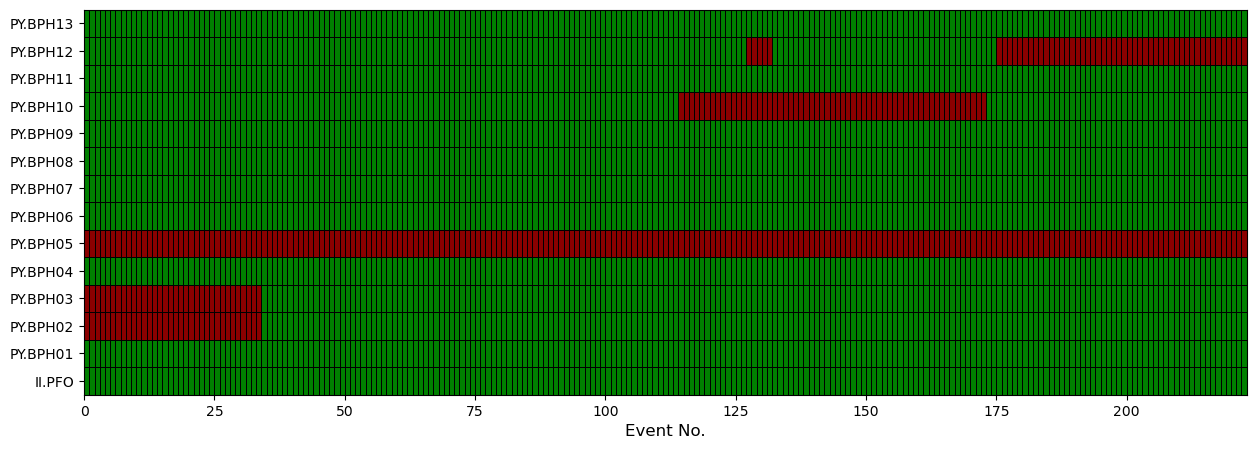

In [38]:
config['array_stations'] = ['II.PFO','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
                            'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']


import matplotlib.colors

fig, ax = plt.subplots(1,1,figsize=(15,5))

cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

ax.pcolormesh(np.array(adr_status).T, cmap=cmap, edgecolors="k", lw=0.5)

ax.set_yticks(np.arange(0,len(config['array_stations']))+0.5, labels=config['array_stations'])

ax.set_xlabel("Event No.",fontsize=12)

plt.show();

## Testing Signal-to-Noise ratios

In [9]:
# from numpy import nanmean, sqrt

# win_length_sec = 10 ## seconds

# t_trigger = events.trigger_time[jj]
# t_rel_sec = t_trigger-config['tbeg']
# fig, ax = plt.subplots(len(st0),1, figsize=(15,15))

# for i, tr in enumerate(st0):

#     df = tr.stats.sampling_rate

#     NN = int(df * win_length_sec) ## samples

#     t_rel_spl = t_rel_sec*df ## samples

#     t_offset = df * 2 ## samples

#     noise = nanmean(tr.data[int(t_rel_spl-NN):int(t_rel_spl)]**2)
#     signal = nanmean(tr.data[int(t_rel_spl):int(t_rel_spl+NN)]**2)

#     SNR = sqrt(signal/noise)



#     ax[i].plot(tr.data)

#     ax[i].axvline(t_rel_spl, color="red")
#     ax[i].axvline(t_rel_spl+NN, color="red")

#     ax[i].axvline(t_rel_spl, color="g")
#     ax[i].axvline(t_rel_spl-NN, color="g")

#     print(SNR)

# plt.show();
